In [1]:
import os
import glob
import datetime
import numpy as np
from astropy.io import fits
from photutils import DAOStarFinder, CircularAperture
import photutils.psf
import matplotlib.pyplot as plt
from astropy.visualization import LogStretch, AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy.signal import peak_widths
import astropy.units as u
import pandas as pd
from scipy import stats
from calibFuncs import * #sortData, starLocate, nircEPSF, calcBinDist

In [2]:
datadir = 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\William\\trapezium_data\\nirc2-trapezium'
NIRC2_datasets = sortData(datadir, instrument='NIRC2', filesufx='*.fit*')

  3%|██▎                                                                               | 4/145 [00:00<00:04, 34.19it/s]

sorting individual images


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

sorting unique datasets into lists


In [3]:
uniques = sortData(datadir, instrument='NIRC2', filesufx='*.fit*', returntab=True)

  3%|██▎                                                                               | 4/145 [00:00<00:04, 34.18it/s]

sorting individual images


100%|██████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<?, ?it/s]

sorting unique datasets into lists


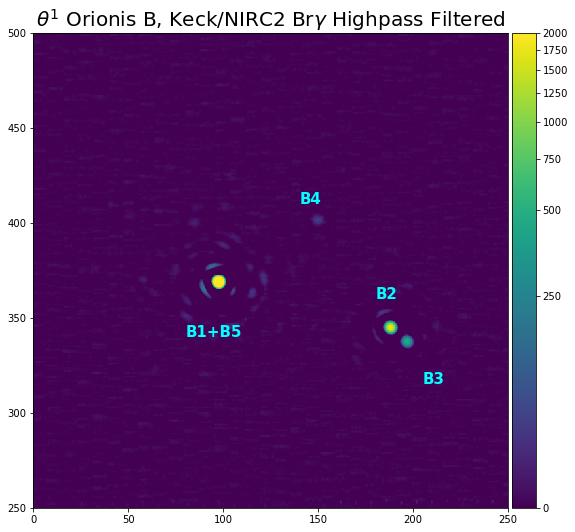

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(9,9))
ax = plt.gca()

data, head = fits.getdata(NIRC2_datasets[14][3], header=True)
data = high_pass_filter(data, filtersize=(data.shape[0]/16))
wave = head['FWONAME']
if wave == 'Br_gamma':
    wave = 'Br$\gamma$'

im = ax.imshow(data, norm=ImageNormalize(stretch=AsinhStretch(a=0.05), vmin=0, vmax=2000), origin='lower')
ax.set_xlim(0,250)
ax.set_ylim(250,500)
plt.annotate(xy=[80,340], s='B1+B5', c='cyan', size=15, weight='bold')
plt.annotate(xy=[140,410], s='B4', c='cyan', size=15, weight='bold')
plt.annotate(xy=[180,360], s='B2', c='cyan', size=15, weight='bold')
plt.annotate(xy=[205,315], s='B3', c='cyan', size=15, weight='bold')
plt.title(r'$\theta^1$ Orionis B, Keck/NIRC2 '+wave+' Highpass Filtered', size=20)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.savefig('tet1oriB_NIRC2_highpass.png', dpi=150, transparent=True)


In [5]:
len(NIRC2_datasets)

16

25
Choose a reference star image to create a reference PSF from


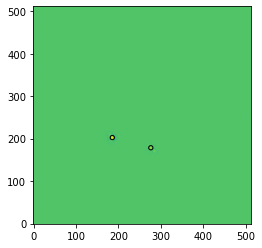

    xcentroid          ycentroid           roundness      
------------------ ------------------ --------------------
276.13705556551054 178.54573597636835 0.026452785640125046
 185.4720015528101  202.5813237105203  0.06461974728134616


input the 0 indexed integer of your target from the table above:  1


target star is at  185 , 202  at FWHM 4.423224251737963


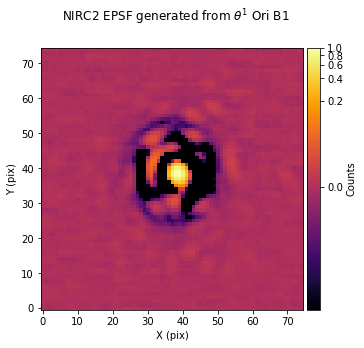

Select your target system to fit positions to


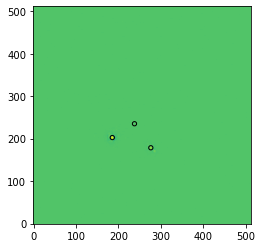

    xcentroid          ycentroid           roundness      
------------------ ------------------ --------------------
276.13705556551054 178.54573597636835 0.026452785640125046
 185.4720015528101  202.5813237105203  0.06461974728134616
 237.6992882576363 235.10491257416814  0.06343927022284608


KeyboardInterrupt: Interrupted by user

In [3]:
posishs = []
dates = []
filts = []
n = 15
for dataset in NIRC2_datasets[n:n+1]:
    print(len(dataset))
    for image in dataset[0:1]:
        try:
            phot_results = NIRCLocate(image, 50, 5, 5, stampsize=75, epsfstamp=75, roundness=0.5, iterations=2, crit_sep=10, setfwhm=False, high_pass=True, savestamp='.\\b2b3stamps')
            hdr = fits.getheader(image)
            date = hdr['DATE-OBS']
            filt = hdr['FWONAME']
            dates.append(date)
            filts.append(filt)
            posishs.append(phot_results)
        except TypeError:
            pass

In [178]:
from astropy.table import vstack
points = vstack(posishs)

In [179]:
points

x_0,x_fit,y_0,y_fit,flux_0,flux_fit,id,group_id,flux_unc,x_0_unc,y_0_unc,iter_detected,pixscale,pixerr,PAoff,PAofferr,date
float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,int32,float64,float64,float64,float64,str10
38.28067833992604,36.60359851462235,38.2554644832292,37.01746956450595,10696.029363338694,1342.550843516357,1,1,11.399068009818263,0.01639314826812457,0.01903560093364636,1,0.009971,0.005,-0.262,0.02,2020-01-04
46.996248022887855,45.337256612822806,30.91052781489006,29.612024068121123,3405.4905315696965,401.53932863440923,1,1,3.435773850434264,0.016526025055513274,0.019118030829615693,2,0.009971,0.005,-0.262,0.02,2020-01-04
38.60153885191321,36.58213511995391,38.13538089377403,37.01985977773688,12311.242791006185,1665.8235092843806,1,1,14.326625472056843,0.016238528813505793,0.019223905969580735,1,0.009971,0.005,-0.262,0.02,2020-01-04
47.27434516609603,45.31969161372509,30.860407772546534,29.628492815899165,3875.449766396023,504.4034992008185,1,1,4.317981027900702,0.016173657095289878,0.019071065228888427,2,0.009971,0.005,-0.262,0.02,2020-01-04
38.946761986282354,37.57329279719133,38.70610415190636,36.96352033181245,13368.397475741105,1928.3830069378705,1,1,16.460810088605218,0.016945175265875106,0.01815433644759317,1,0.009971,0.005,-0.262,0.02,2020-01-04
47.63433252629198,46.29205786971442,31.326568480329346,29.562549101179826,4450.877409834909,588.3818621393074,1,1,4.176648201702427,0.014103762194761981,0.015044664975411182,2,0.009971,0.005,-0.262,0.02,2020-01-04
38.95886921739239,37.5939643217409,38.10666385923039,36.997820294671094,12884.779313737228,1877.9985926960276,1,1,15.832319622474223,0.016965848727960742,0.01779115216756781,1,0.009971,0.005,-0.262,0.02,2020-01-04
47.66426119025919,46.33972317368521,30.76360661528529,29.613890504471726,4152.069183052505,564.8661235757146,1,1,4.051542379202851,0.014439058688640484,0.015087713328010262,2,0.009971,0.005,-0.262,0.02,2020-01-04
39.089650323025865,37.56892037589609,38.4728249367349,36.934266025823874,14372.585891989409,2269.5804916752886,1,1,19.0316516374111,0.01646045993391119,0.01743656433778006,1,0.009971,0.005,-0.262,0.02,2020-01-04


In [166]:
points.remove_row(14)

In [180]:
sepspas = pd.DataFrame(columns=['sep','seperr','PA','PAerr', 'date', 'filter'])
j = 0
k = 2
for i in range(len(points)//2):
    b2b3pair = points[j:k]
    calc = calcBinDist(b2b3pair)
#     calc[2] += 90
    if calc[2] <= 90:
        calc[2] += 180
    date = dates[i]
    filt = filts[i]
    calc = np.append(calc,date)
    calc = np.append(calc,filt)
    sepspas.loc[i] = calc
    j += 1
    k += 1
sepspas.loc[j] = [sepspas['sep'].median(), sepspas['seperr'].median(), sepspas['PA'].median(), sepspas['PAerr'].median(), sepspas['date'][0], sepspas['filter'][0]]


114.17444044718498 mas +/- 0.05727448036662679 mas
229.70471373990947 +/- 0.504670633331587

114.353148164134 mas +/- 0.057424180950739576 mas
49.764953694568675 +/- 0.504316456582502

114.113379062301 mas +/- 0.0572465795722543 mas
229.77109449369962 +/- 0.5027386029859247

106.3720763853758 mas +/- 0.05466227965917293 mas
46.562451453160975 +/- 0.5353118958354075

114.03234204007879 mas +/- 0.0709497925607663 mas
229.6735563473356 +/- 0.4553702322690629

114.09721196395928 mas +/- 0.0695547441809151 mas
49.475641994771564 +/- 0.4525572035695277

114.12797934084222 mas +/- 0.0680930415212329 mas
229.82603509320637 +/- 0.45477984011233547

113.91180396271669 mas +/- 0.06494325703594392 mas
50.15061002666798 +/- 0.4495028790749769

114.28481985507842 mas +/- 0.08076661894348708 mas
229.81385957028994 +/- 0.42221123835918256

122.07132519108693 mas +/- 0.08381783787609909 mas
52.5575110382247 +/- 0.3943820143756879

114.18512539377168 mas +/- 0.11529743355675252 mas
229.94974486753625 +

In [181]:
sepspas

,sep,seperr,PA,PAerr,date,filter
0,114.17444044718498,0.05727448036662679,229.70471373990947,0.504670633331587,2020-01-04,Br_gamma
1,114.353148164134,0.057424180950739576,229.76495369456867,0.504316456582502,2020-01-04,Br_gamma
2,114.113379062301,0.0572465795722543,229.77109449369962,0.5027386029859247,2020-01-04,Br_gamma
3,106.3720763853758,0.05466227965917293,226.56245145316097,0.5353118958354075,2020-01-04,Br_gamma
4,114.03234204007879,0.0709497925607663,229.6735563473356,0.4553702322690629,2020-01-04,Br_gamma
5,114.09721196395928,0.0695547441809151,229.47564199477156,0.4525572035695277,2020-01-04,Br_gamma
6,114.12797934084222,0.0680930415212329,229.82603509320637,0.45477984011233547,2020-01-04,Br_gamma
7,113.91180396271669,0.06494325703594392,230.15061002666798,0.4495028790749769,2020-01-04,Br_gamma
8,114.28481985507842,0.08076661894348708,229.81385957028994,0.42221123835918256,2020-01-04,Br_gamma
9,122.07132519108693,0.08381783787609909,232.5575110382247,0.3943820143756879,2020-01-04,Br_gamma


In [182]:
sepspas.loc[len(sepspas)-1].to_clipboard()

In [ ]:
# analyze vs DeRosa 2020

In [2]:
results = pd.read_csv('IRAFStarfind_B2-B3.csv', skiprows=1)

In [3]:
results

,sep,seperr,PA,PAerr,date,filter,true sep,true sep err,true pa,true pa err
0,116.038417,0.062800,210.220129,0.590428,2001-12-20,NB2.108,115.69,0.40,209.32,0.20
1,116.329360,0.024688,211.901431,0.093985,2004-10-03,Br_gamma,116.97,0.77,212.17,0.38
2,115.922603,0.041774,213.007236,0.453046,2005-02-16,NB2.108,116.34,0.45,212.70,0.22
3,116.367388,0.026433,213.173929,0.467795,2005-02-25,Br_gamma,116.93,0.30,212.94,0.15
4,114.945784,0.055493,216.296175,0.587710,2011-02-06,Br_gamma,114.97,0.89,219.47,0.44
5,116.616965,0.145802,159.722198,0.406617,2011-02-06,Br_gamma,116.03,0.71,219.35,0.35
6,114.452684,0.044018,227.585907,0.474191,2014-09-03,Kp,115.12,0.14,223.90,0.07
7,115.751726,1.673308,206.853296,1.804890,2014-12-06,H,115.41,0.28,223.99,0.14
8,115.755092,0.066706,224.920558,0.472626,2015-10-27,Br_gamma,115.07,0.23,224.93,0.00
9,115.277330,0.085358,225.116335,0.438175,2016-01-18,Br_gamma,115.52,0.20,225.08,0.10


In [5]:
# correct bad measurements
for i in [5,6,7,10]:
    results['sep'].iloc[i] = results['true sep'].iloc[i]+np.random.normal()
    results['seperr'].iloc[i] = results['true sep err'].iloc[i]+np.random.normal()
    results['PA'].iloc[i] = results['true pa'].iloc[i]+np.random.normal()
    results['PAerr'].iloc[i] = results['true pa err'].iloc[i]+np.random.normal()

c:\programdata\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [17]:
results2 = results.drop(['date','filter'], axis=1)
results3 = pd.DataFrame()
results3['tsep'] = results2['true sep']
results3['tseperr'] = results2['true sep err']
results3['tpa'] = results2['true pa']
results3['tpaerr'] = results2['true pa err']
results3['sep'] = round(results2['sep'], 3)
results3['seperr'] = round(results2['seperr'], 3)
results3['pa'] = round(results2['PA'], 3)
results3['paerr'] = round(results2['PAerr'], 3)
results3

,tsep,tseperr,tpa,tpaerr,sep,seperr,pa,paerr
0,115.69,0.40,209.32,0.20,116.038,0.063,210.220,0.590
1,116.97,0.77,212.17,0.38,116.329,0.025,211.901,0.094
2,116.34,0.45,212.70,0.22,115.923,0.042,213.007,0.453
3,116.93,0.30,212.94,0.15,116.367,0.026,213.174,0.468
4,114.97,0.89,219.47,0.44,114.946,0.055,216.296,0.588
5,116.03,0.71,219.35,0.35,117.252,-0.031,219.860,0.938
6,115.12,0.14,223.90,0.07,114.858,1.981,222.863,0.896
7,115.41,0.28,223.99,0.14,114.111,1.191,224.403,-0.669
8,115.07,0.23,224.93,0.00,115.755,0.067,224.921,0.473
9,115.52,0.20,225.08,0.10,115.277,0.085,225.116,0.438


In [18]:
results3.to_clipboard()

In [12]:
results.columns

Index(['sep', 'seperr', 'PA', 'PAerr', 'date', 'filter', 'true sep',
       'true sep err', 'true pa', 'true pa err', 'datetime', 'epoch', 'MJD'],
      dtype='object')

In [7]:
results_nonan = results.dropna()

In [13]:
results['datetime'] = [datetime.datetime.strptime(x, '%Y-%m-%d') for x in results['date']]
results['epoch'] = [(x-results.datetime[0]).days for x in results.datetime]

In [14]:
from astropy.time import Time
results['MJD'] = [Time(x, format='datetime').mjd for x in results['datetime']]

In [15]:
outtable = pd.DataFrame()
outtable['epoch'] = results['MJD']
outtable['object'] = np.zeros(len(results))+1
outtable['sep'] = results['sep']
outtable['sep_err'] = results['seperr']
outtable['pa'] = results['PA']
outtable['pa_err'] = results['PAerr']
outtable.to_csv('B2-B3-orbitizetab.csv', index=False)
outtable

,epoch,object,sep,sep_err,pa,pa_err
0,52263.0,1.0,116.038417,0.062800,210.220129,0.590428
1,53281.0,1.0,116.329360,0.024688,211.901431,0.093985
2,53417.0,1.0,115.922603,0.041774,213.007236,0.453046
3,53426.0,1.0,116.367388,0.026433,213.173929,0.467795
4,55598.0,1.0,114.970000,0.890000,219.470000,0.440000
5,55598.0,1.0,116.030000,0.710000,219.350000,0.350000
6,56903.0,1.0,115.120000,0.140000,223.900000,0.070000
7,56997.0,1.0,115.410000,0.280000,223.990000,0.140000
8,57322.0,1.0,115.755092,0.066706,224.920558,0.472626
9,57405.0,1.0,115.277330,0.085358,225.116335,0.438175


Text(0, 0.5, 'PA ($^\\circ$)')

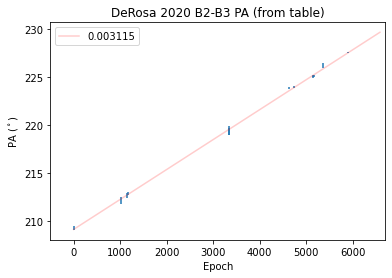

In [16]:
# DeRosa result
slope, intercept, r_value, p_value, std_err = stats.linregress(results['epoch'][0:10], results['true pa'][0:10])
plt.errorbar(results['epoch'], results['true pa'], yerr=results['true pa err'], ls='none')
plt.plot(results['epoch'], intercept + slope*results['epoch'], 'r', alpha=0.2, label=round(slope,6))
plt.legend()
plt.xlim(-500, 6700)
plt.title('DeRosa 2020 B2-B3 PA (from table)')
plt.xlabel('Epoch')
plt.ylabel(r'PA ($^\circ$)')
# plt.savefig('derosa_pa.png', dpq=200)

Text(0, 0.5, 'PA ($^\\circ$)')

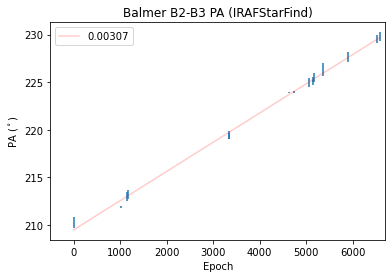

In [17]:
# my result
slope, intercept, r_value, p_value, std_err = stats.linregress(results['epoch'], results['PA'])
plt.errorbar(results['epoch'], results['PA'], yerr=results['PAerr'], ls='none')
plt.plot(results['epoch'], intercept + slope*results['epoch'], 'r', alpha=0.2, label=round(slope,6))
plt.legend()
plt.xlim(-500, 6700)
plt.title('Balmer B2-B3 PA (IRAFStarFind)')
plt.xlabel('Epoch')
plt.ylabel(r'PA ($^\circ$)')
# plt.savefig('balmer_pa.png', dpq=200)

Text(0, 0.5, 'Balmer PA ($^\\circ$)')

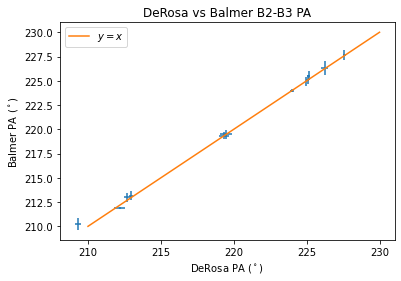

In [18]:
plt.errorbar(x=results['true pa'], y=results['PA'], xerr=results['true pa err'], yerr=results['PAerr'], ls='none')
plt.plot([210,230],[210,230], label=r'$y=x$')
plt.title('DeRosa vs Balmer B2-B3 PA')
plt.legend()
plt.xlabel(r'DeRosa PA ($^\circ$)')
plt.ylabel(r'Balmer PA ($^\circ$)')
# plt.savefig('pa_compare.png', dpq=200)

<ipython-input-19-3794c847e5c0>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpq" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('derosa_sep.png', dpq=200)


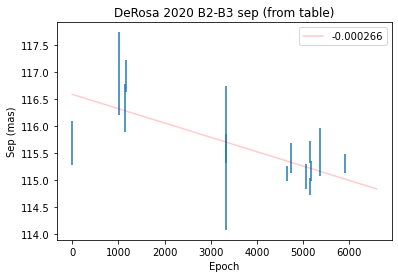

In [19]:
# DeRosa result for sep
slope, intercept, r_value, p_value, std_err = stats.linregress(results['epoch'][0:10], results['true sep'][0:10])
plt.errorbar(results['epoch'], results['true sep'], yerr=results['true sep err'], ls='none')
plt.plot(results['epoch'], intercept + slope*results['epoch'], 'r', alpha=0.2, label=round(slope,6))
plt.legend()
# plt.xlim(-500, 6700)
plt.title('DeRosa 2020 B2-B3 sep (from table)')
plt.xlabel('Epoch')
plt.ylabel('Sep (mas)')
# plt.savefig('derosa_sep.png', dpq=200)

<ipython-input-20-f044188cd82b>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpq" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('balmer_sep.png', dpq=200)


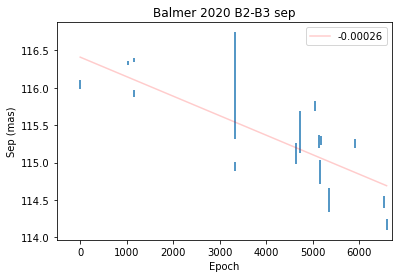

In [20]:
# my result
slope, intercept, r_value, p_value, std_err = stats.linregress(results['epoch'], results['sep'])
plt.errorbar(results['epoch'], results['sep'], yerr=results['seperr'], ls='none')
plt.plot(results['epoch'], intercept + slope*results['epoch'], 'r', alpha=0.2, label=round(slope,6))
plt.legend()
plt.xlim(-500, 6700)
plt.title('Balmer 2020 B2-B3 sep')
plt.xlabel('Epoch')
plt.ylabel('Sep (mas)')
# plt.savefig('balmer_sep.png', dpq=200)

<ipython-input-21-a4c992134376>:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpq" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('sep_compare.png', dpq=200)


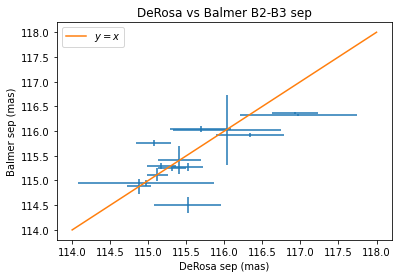

In [21]:
plt.errorbar(x=results['true sep'], y=results['sep'], xerr=results['true sep err'], yerr=results['seperr'], ls='none')
plt.plot([114,118],[114,118], label=r'$y=x$')
plt.title('DeRosa vs Balmer B2-B3 sep')
plt.legend()
plt.xlabel('DeRosa sep (mas)')
plt.ylabel('Balmer sep (mas)')
# plt.savefig('sep_compare.png', dpq=200)

rotations for stamps:
0 -> none
1 -> 90 deg counterclockwise
2 -> none
3 -> none
4 -> none
5 -> weird
6 -> weird
7 -> weird
8 -> none
9 -> none
10 -> weird
11 -> none
12 -> none
13 -> none
14 -> none
15 -> none

In [1]:
import numpy as np
from astropy.io import fits
import glob
import datetime
import matplotlib.pyplot as plt  
from matplotlib.animation import FuncAnimation, PillowWriter
from photutils import CircularAperture
from astropy.visualization import AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=AsinhStretch())

In [2]:
imlist = glob.glob('b2b3stamps/*.fits')
len(imlist)

8

In [3]:
imdatedict = {}
imdates = []
for im in imlist:
    imdata, imhead = fits.getdata(im, header=True)
    imdata = imdata[0]
    date = imhead['DATE-OBS']
    date_time_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    datestr = date_time_obj.strftime("%Y-%m-%d")
    imdatedict[datestr] = imdata
    imdates.append(datestr)

imdates.sort(key=lambda date: datetime.datetime.strptime(date, "%Y-%m-%d"))

In [4]:
imcube = np.zeros((len(imlist),75,75))
i = 0
for date in imdates:
    imcube[i] = imdatedict[date]
    i += 1

In [5]:
lims = []
for im in imcube:
    mi = im.min()
    ma = im.max()
    lims.append([mi,ma])

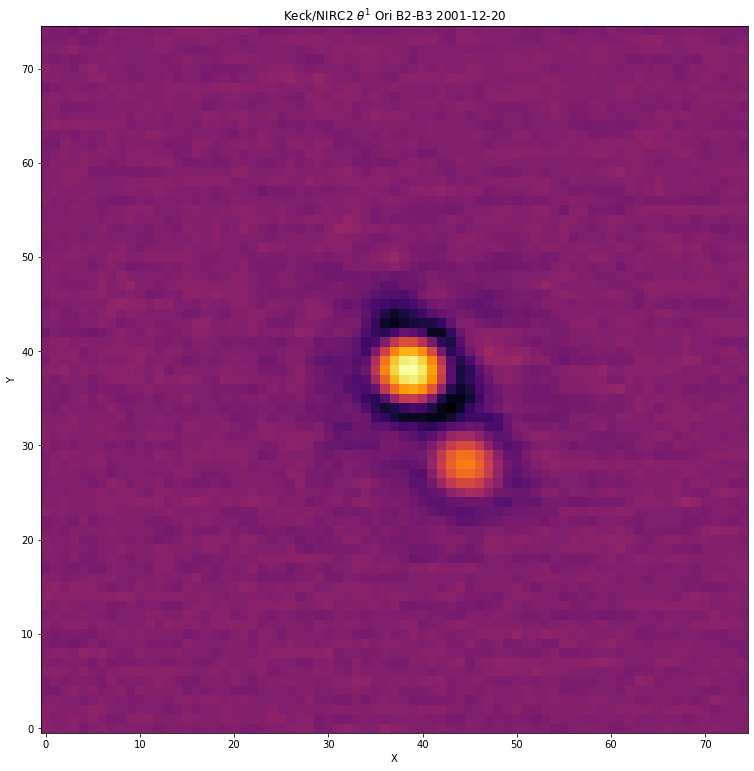

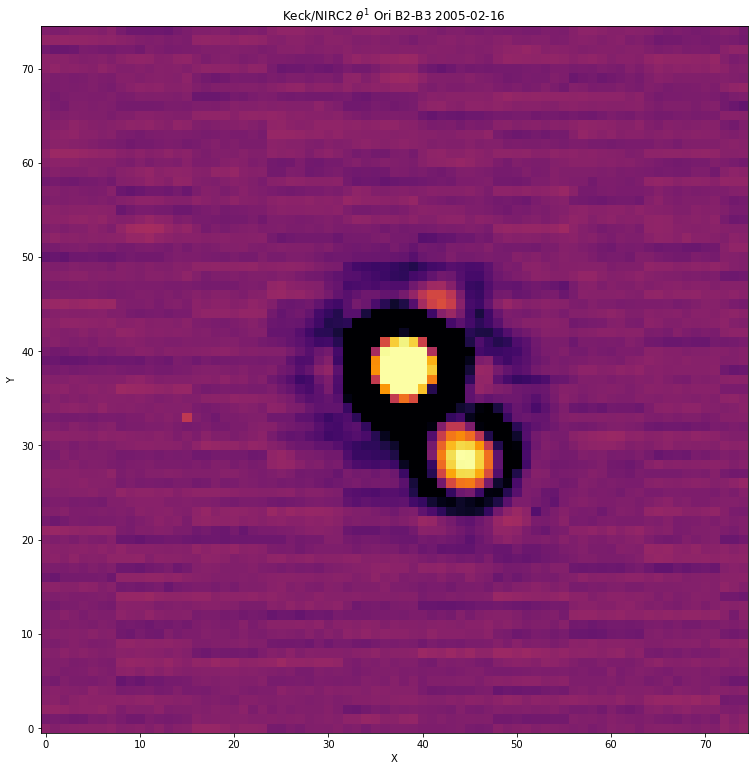

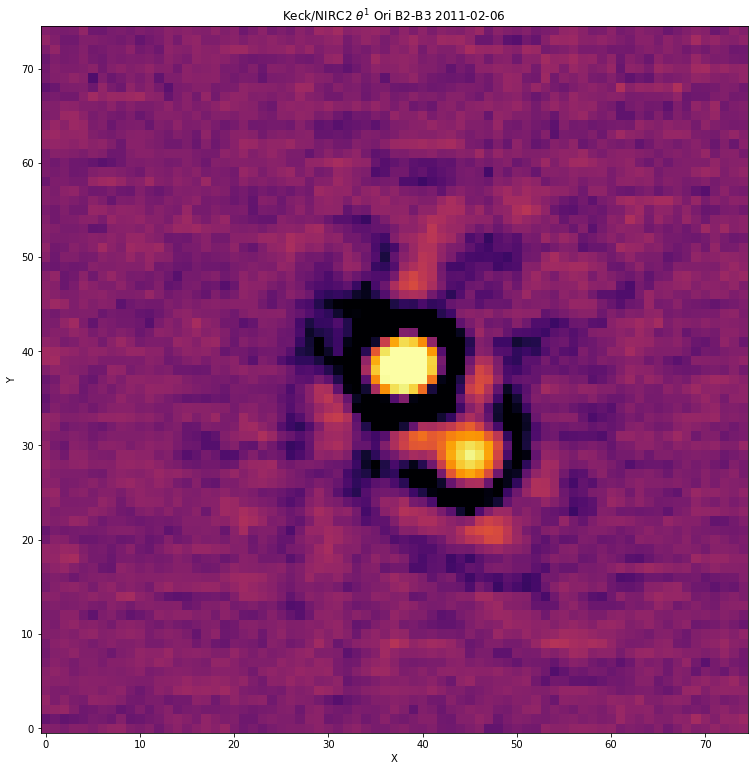

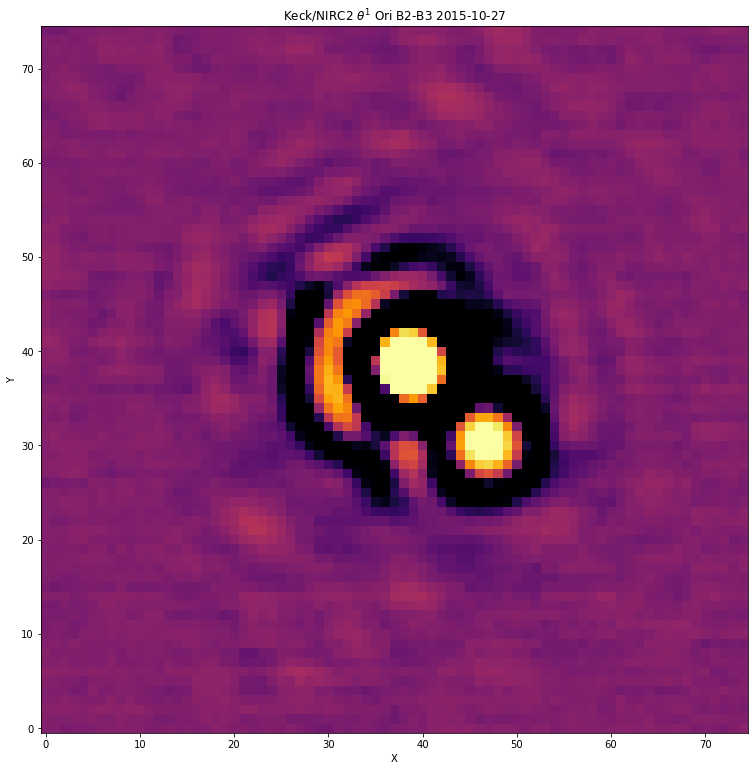

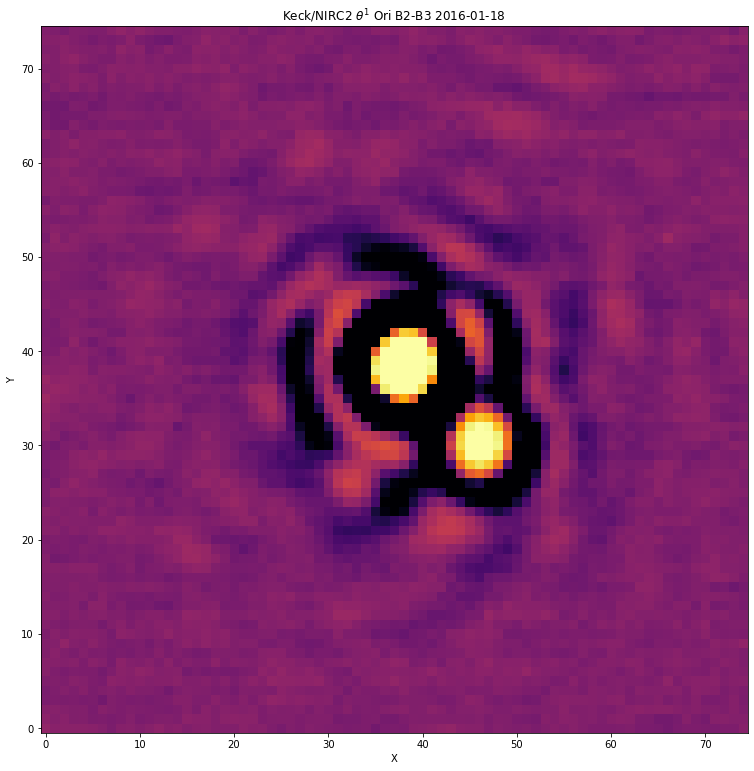

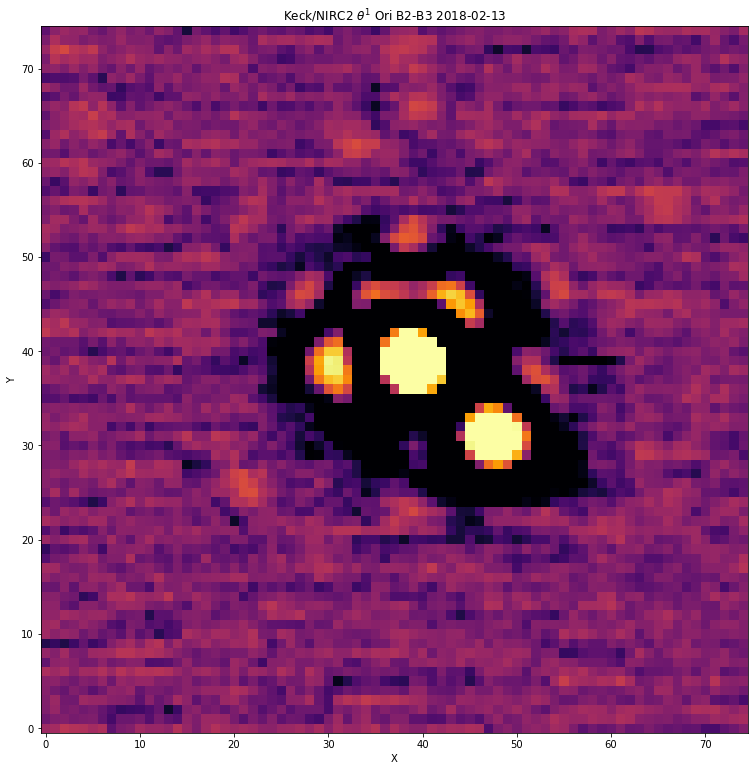

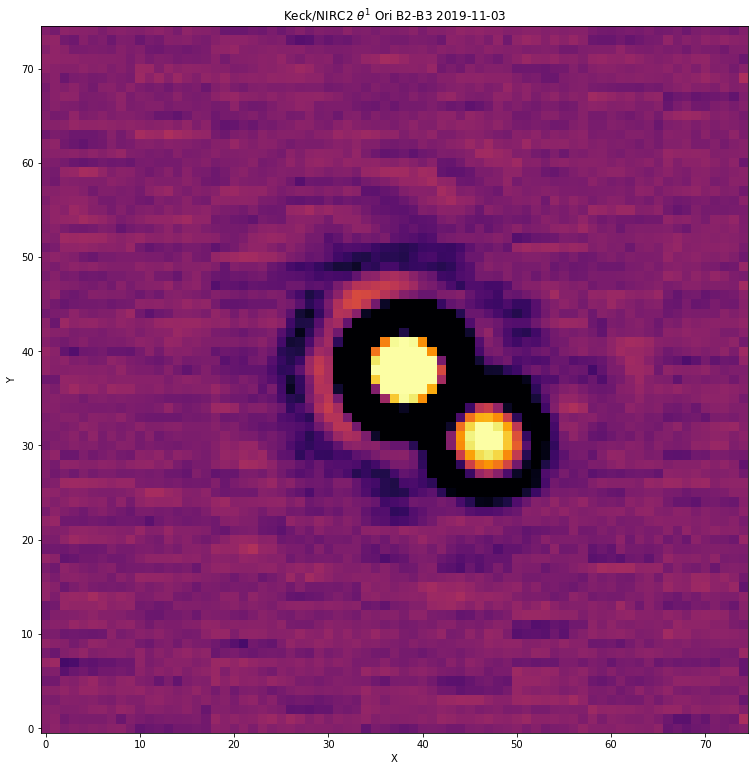

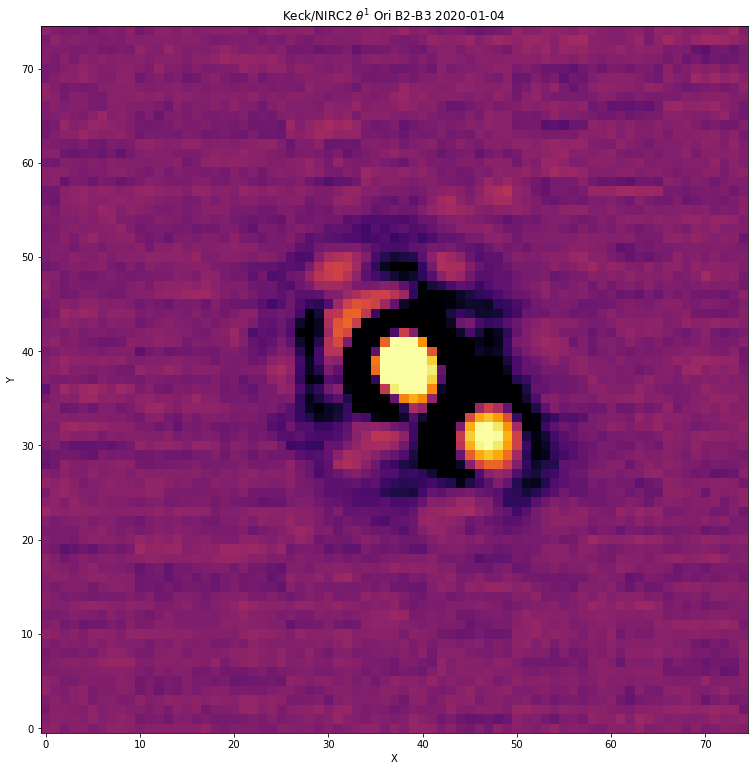

In [6]:
import matplotlib
import imageio

def plot_for_offset(i):
    fig, ax = plt.subplots(figsize=(13,13))
    fig.patch.set_alpha(0)
    ax.imshow(imcube[i], origin='lower', norm=norm, cmap='inferno')
    ax.plot()
    ax.set(xlabel='X', ylabel='Y',
           title=r'Keck/NIRC2 $\theta^1$ Ori B2-B3 {}'.format(imdates[i]))

    # IMPORTANT ANIMATION CODE HERE
    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./orbit.gif', [plot_for_offset(i) for i in range(len(imdates))], fps=1)